In [1]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pylab import *

In [3]:
# Create attribute annotations table
data_import = pd.read_table('data/list_attr_celeba.txt', delim_whitespace=True)
data = data_import.replace(-1, 0)
data['Beard'] = 1 - data['No_Beard']
data = data.drop('No_Beard', axis=1)
data.to_csv("data/attribute_annotations_ALL.csv")




# Create Face Alignment Column
df = pd.read_csv('landmarks_cropped_df.csv', index_col=0)  # load saved landmark_table
df = df.replace(0.0, np.nan).dropna()

# Create function to calculate face angle factor
def calc_angle(left, right, center):
    left_dist = np.absolute(center - left)
    right_dist = np.absolute(center - right)
    if left_dist >= right_dist:
        alignment = right_dist / left_dist
    else:
        alignment = left_dist / right_dist
    return alignment

# Apply function and generate new column to dataframe
df['Alignment'] = df.apply(lambda x: calc_angle(x['0x'], x['16x'], x['30x']), axis=1)
df['Alignment'].to_csv('Face_Alignment_df.csv')

In [5]:
annotations = pd.read_csv('data/attribute_annotations_ALL.csv',index_col=0)
male_beard = annotations[['Male','Beard','5_o_Clock_Shadow','Young','Black_Hair','Brown_Hair']]
male_beard.head()

,Male,Beard,5_o_Clock_Shadow,Young,Black_Hair,Brown_Hair
000001.jpg,0,0,0,1,0,1
000002.jpg,0,0,0,1,0,1
000003.jpg,1,0,0,1,0,0
000004.jpg,0,0,0,1,0,0
000005.jpg,0,0,0,1,0,0


Import list of images in final directory. Left join onto this key list afterwards.

In [7]:
faces_detected = pd.DataFrame(index=os.listdir('images/celeba_aligned_cropped'))
df_1=pd.merge(faces_detected, male_beard, how='left', left_index=True, right_index=True)
df_1.head()

,Male,Beard,5_o_Clock_Shadow,Young,Black_Hair,Brown_Hair
000001.jpg,0,0,0,1,0,1
000002.jpg,0,0,0,1,0,1
000005.jpg,0,0,0,1,0,0
000006.jpg,0,0,0,1,0,1
000007.jpg,1,0,1,1,1,0


Import alignment score and join:

In [9]:
alignment_score = pd.read_csv('data/Face_Alignment_df.csv',
                              header=None, index_col=0,
                              names=['face_alignment'])

df_2 = pd.merge(df_1, alignment_score, how='left', left_index=True, right_index=True)
df_2.head()

,Male,Beard,5_o_Clock_Shadow,Young,Black_Hair,Brown_Hair,face_alignment
000001.jpg,0,0,0,1,0,1,0.281407
000002.jpg,0,0,0,1,0,1,0.396648
000005.jpg,0,0,0,1,0,0,0.819672
000006.jpg,0,0,0,1,0,1,0.455128
000007.jpg,1,0,1,1,1,0,0.760870


Import skin tone score:

In [10]:
# COMMENT THIS OUT IF YOU DON"T RUN THE SKIN TONE FILE; also change the "df_3/4" names in the following cell
skin_tone_df = pd.read_csv('skin_tone_df.csv', index_col=0).dropna()
df_3 = pd.merge(df_2, skin_tone_df, how='left', left_index=True, right_index=True)
df_3.head()

,Male,Beard,5_o_Clock_Shadow,Young,Black_Hair,Brown_Hair,face_alignment,Skin_tone
000001.jpg,0,0,0,1,0,1,0.281407,209.021771
000002.jpg,0,0,0,1,0,1,0.396648,165.153542
000005.jpg,0,0,0,1,0,0,0.819672,188.380417
000006.jpg,0,0,0,1,0,1,0.455128,165.938438
000007.jpg,1,0,1,1,1,0,0.760870,192.087604


Import train_test_val groups:

In [11]:
train_test_val = pd.read_table('data/list_eval_partition.txt', delim_whitespace=True,
                              index_col=0,header=None,names=['Group'])

df_4 = pd.merge(df_3, train_test_val, how='left', left_index=True, right_index=True)
df_4.head()

,Male,Beard,5_o_Clock_Shadow,Young,Black_Hair,Brown_Hair,face_alignment,Skin_tone,Group
000001.jpg,0,0,0,1,0,1,0.281407,209.021771,0
000002.jpg,0,0,0,1,0,1,0.396648,165.153542,0
000005.jpg,0,0,0,1,0,0,0.819672,188.380417,0
000006.jpg,0,0,0,1,0,1,0.455128,165.938438,0
000007.jpg,1,0,1,1,1,0,0.760870,192.087604,0


Filter dataset and save to csv:

In [12]:
final_df = df_4[(df_4['Male'] == 1) & 
                (df_4['face_alignment'] > .7) & 
                (df_4['Skin_tone'] > 140) &
                (df_4['Skin_tone'] < 195) &
               ((df_4['Black_Hair'] == 1) | (df_4['Brown_Hair'] == 1))]
final_df = final_df[['Beard','5_o_Clock_Shadow','Young','Black_Hair','Brown_Hair','Group']]

In [13]:
final_df.to_csv("data/attribute_reference_df.csv")
print("Final_df total samples:", final_df.shape[0])
print("Final_df total beard samples:", final_df['Beard'].sum())

Final_df total samples: 11757
Final_df total beard samples: 4999


Copy images into a final directories:

In [22]:
# THIS CELL IS USED TO POPULATE IMAGE FOLDER FOR ATTRIBUTE VECTOR CALCULATION FUNCTION
# RUN THIS CELL

# populate train_NO_attribute image folder
shutil.rmtree('data/final_images_train', ignore_errors=True)
os.makedirs('data/final_images_train')
final_df_train = final_df[final_df['Group'] == 0]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/final_images_train')

In [ ]:
# RUN THIS IF YOU PLAN ON TRAINING CLEAN TO BEARD MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING CLEAN TO BEARD MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING CLEAN TO BEARD MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING CLEAN TO BEARD MODEL; DO NOT RUN OTHERWISE

# populate train_NO_attribute image folder
shutil.rmtree('/data/train', ignore_errors=True)
os.makedirs('data/train/no_attribute')
os.makedirs('data/train/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 0) & (final_df['Beard'] == 0)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/train/no_attribute')
    
    
# populate validation_NO_attribute image folder
shutil.rmtree('/data/val', ignore_errors=True)
os.makedirs('data/val/no_attribute')
os.makedirs('data/val/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 1) & (final_df['Beard'] == 0)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/val/no_attribute')
    
    
    
# populate test_NO_attribute image folder
shutil.rmtree('/data/test', ignore_errors=True)
os.makedirs('data/test/no_attribute')
os.makedirs('data/test/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 2) & (final_df['Beard'] == 0)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/test/no_attribute')

In [ ]:
# RUN THIS IF YOU PLAN ON TRAINING BEARD TO CLEAN MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING BEARD TO CLEAN MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING BEARD TO CLEAN MODEL; DO NOT RUN OTHERWISE
# RUN THIS IF YOU PLAN ON TRAINING BEARD TO CLEAN MODEL; DO NOT RUN OTHERWISE

# populate train_YES_attribute image folder
shutil.rmtree('/data/train', ignore_errors=True)
os.makedirs('data/train/no_attribute')
os.makedirs('data/train/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 0) & (final_df['Beard'] == 1)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/train/yes_attribute')
    
    
# populate validation_YES_attribute image folder
shutil.rmtree('/data/val', ignore_errors=True)
os.makedirs('data/val/no_attribute')
os.makedirs('data/val/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 1) & (final_df['Beard'] == 1)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/val/yes_attribute')
    
    
    
# populate test_YES_attribute image folder
shutil.rmtree('/data/test', ignore_errors=True)
os.makedirs('data/test/no_attribute')
os.makedirs('data/test/yes_attribute')
final_df_train = final_df[(final_df['Group'] == 2) & (final_df['Beard'] == 1)]
final_images_train = final_df_train.index
for image in final_images_train:
    image = 'data/celeba_aligned_cropped/'+image
    shutil.copy(image, 'data/test/yes_attribute')

In [1]:
# EVERYTHING BELOW IS IS NOT NECESSARY TO RUN

In [ ]:
# THIS CELL WAS USED TO EXAMINE SUBGROUPS OF BEARDS

# populate train image folder
final_df_train = final_df[(final_df['Beard'] == 1) & (final_df['5_o_Clock_Shadow'] == 0)]
final_images_train = final_df_train.index[:500]
for image in final_images_train:
    image = 'images/celeba_aligned_cropped/'+image
    shutil.copy(image, 'images/just_beard')

In [78]:
# populate train image folder
final_df_train = final_df[(final_df['Beard'] == 1) & (final_df['Young'] == 1)]
final_images_train = final_df_train.index[:500]
for image in final_images_train:
    image = 'images/celeba_aligned_cropped/'+image
    shutil.copy(image, 'images/beard_shadow')

[Text(0, 0, 'Total Raw Images'),
 Text(0, 0, 'Face Undetected'),
 Text(0, 0, 'Male'),
 Text(0, 0, 'Face Alignment'),
 Text(0, 0, 'Facial Color Tone'),
 Text(0, 0, 'Final Images')]

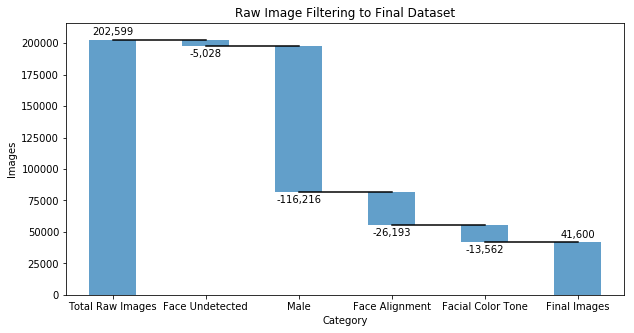

In [23]:
index = ['Total Raw Images','Face Undetected','Male','Face Alignment','Facial Color Tone']
data = {'amount': [202599, -5028, -116216, -26193, -13562]}

#Store data and create a blank series to use for the waterfall
trans = pd.DataFrame(data=data,index=index)
blank = trans.amount.cumsum().shift(1).fillna(0)

#Get the net total number for the final element in the waterfall
total = trans.sum().amount
trans.loc["Final Images"]= total
blank.loc["Final Images"] = total

#The steps graphically show the levels as well as used for label placement
step = blank.reset_index(drop=True).repeat(3).shift(-1)
step[1::3] = np.nan

#When plotting the last element, we want to show the full bar,
#Set the blank to 0
blank.loc["Final Images"] = 0

#Plot and label
my_plot = trans.plot(kind='bar', stacked=True, bottom=blank,legend=None,
                     figsize=(10, 5), alpha=.7, title="Raw Image Filtering to Final Dataset")
my_plot.plot(step.index, step.values,'k')
my_plot.tick_params(top=False, right=False)
my_plot.set_xlabel("Category")
my_plot.set_ylabel("Images")

#Format the axis for dollars
# my_plot.yaxis.set_major_formatter(formatter)

#Get the y-axis position for the labels
y_height = trans.amount.cumsum().shift(1).fillna(0)

#Get an offset so labels don't sit right on top of the bar
max = trans.max()
neg_offset = max / 25
pos_offset = max / 50
plot_offset = int(max / 15)

#Start label loop
loop = 0
for index, row in trans.iterrows():
    # For the last item in the list, we don't want to double count
    if row['amount'] == total:
        y = y_height[loop]
    else:
        y = y_height[loop] + row['amount']
    # Determine if we want a neg or pos offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    my_plot.annotate("{:,.0f}".format(row['amount']),(loop,y),ha="center")
    loop+=1

#Scale up the y axis so there is room for the labels
my_plot.set_ylim(0,blank.max()+int(plot_offset))
#Rotate the labels
my_plot.set_xticklabels(trans.index,rotation=0)
# my_plot.get_figure().savefig("waterfall.png",dpi=200,bbox_inches='tight')

